In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import cv2 as cv

In [2]:
def show(image, title=None, figsize=(6,6), colormap='gray'):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(image, colormap)

#### 0. Image loading.

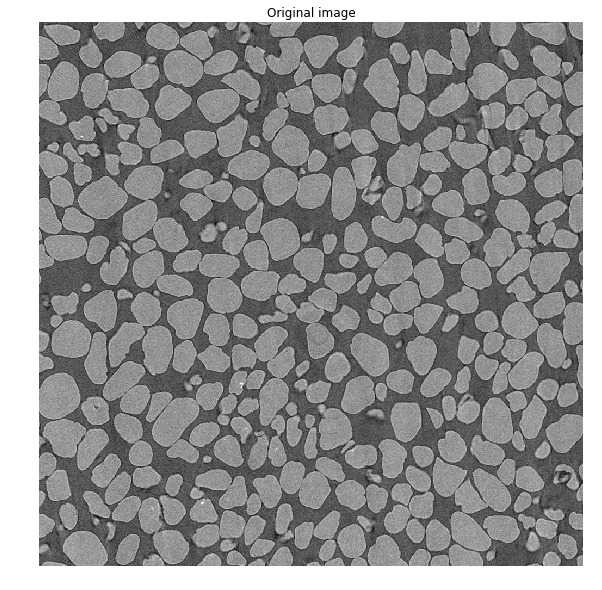

In [3]:
imgpath = './0.png'
img = cv.imread(imgpath)
grayscale = cv.imread(imgpath, 0)

show(img, 'Original image', (10,10))

#### 1. Edge enhancement with unsharp mask.

In [4]:
def unsharp_mask(image, kernel_size=(5,5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

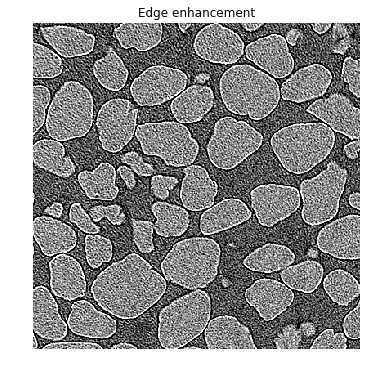

In [5]:
unsharp = unsharp_mask(grayscale, amount=6, threshold=0)

show(unsharp[:400,:400], 'Edge enhancement')

#### 2. Otsu's thresholding with bilateral blur.

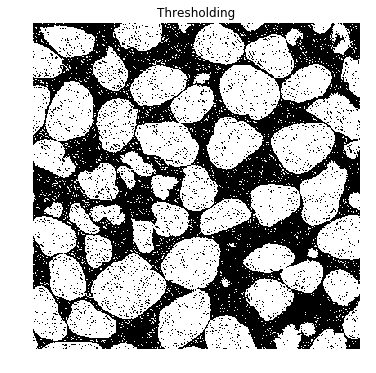

In [6]:
bilateral_blur = cv.bilateralFilter(unsharp, 9, 75, 75)
ret, th = cv.threshold(bilateral_blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

show(th[:400,:400], "Thresholding")

#### 3. Noise reduction.

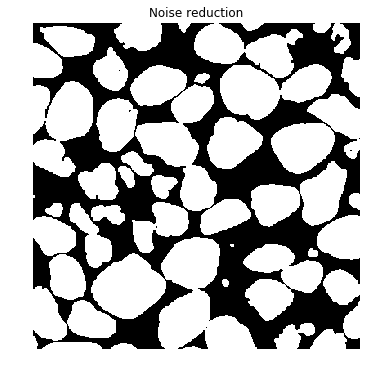

In [7]:
kernel = np.ones((3,3), np.uint8)  # TODO: Try another kernel? 

m_blur = cv.medianBlur(th, 3)
m_blur = cv.medianBlur(m_blur, 3)
opening = cv.morphologyEx(m_blur, cv.MORPH_OPEN, kernel, iterations = 1)

show(opening[:400,:400], "Noise reduction")

#### 4. Watershed segmentation of touching particles.

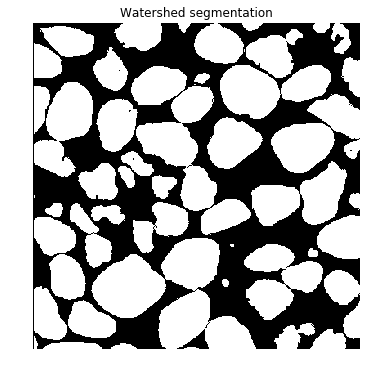

In [8]:
kernel = np.ones((3,3), np.uint8)

# sure background area
sure_bg = cv.dilate(opening, kernel, iterations=2)

# foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 0)
dist_transform = cv.normalize(dist_transform, dist_transform, 0, 255, cv.NORM_MINMAX)
ret, sure_fg = cv.threshold(dist_transform, 0.23 * dist_transform.max(), 255, 0)

# unknown region
sure_fg = sure_fg * 100000
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
markers[unknown==255] = 0

markers = cv.watershed(img, markers)

bordered = opening
bordered[markers == -1] = 0
show(bordered[:400, :400], 'Watershed segmentation')

#### 5. Contour detection.

In [9]:
bordered = cv.convertScaleAbs(bordered)
bordered = cv.erode(bordered, kernel, iterations=1) # Separation of touching particles.

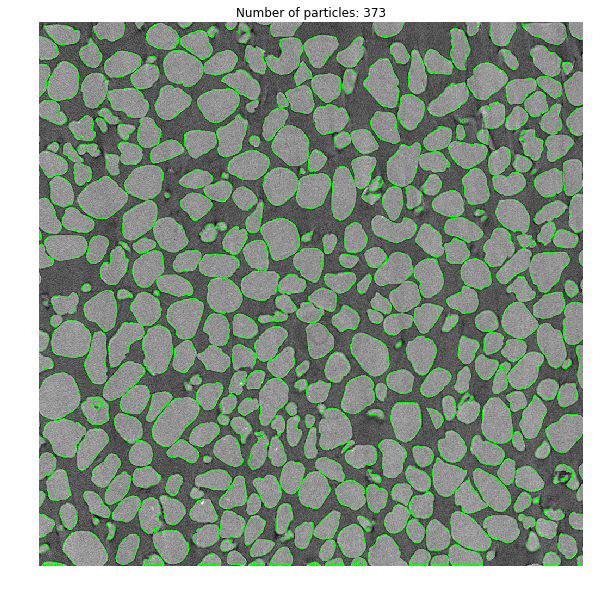

In [10]:
contours, hierarchy = cv.findContours(bordered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

contours = [c for c in contours if cv.contourArea(c)>5]  # Filtering erroneous contours (with tiny areas).
moments = [cv.moments(c) for c in contours]
centroids = [(int(m['m10']/m['m00']), int(m['m01']/m['m00'])) for m in moments]

# Scaling contours up (to revert errosion effect).
contours = [np.asarray(((c - cent)*1.05)+cent, int) for c, cent in zip(contours, centroids)]

result = cv.cvtColor(grayscale, cv.COLOR_GRAY2RGB)
cv.drawContours(result, contours, -1, (0,255,0), thickness=1, lineType=cv.LINE_AA)
show(result, 'Number of particles: {}'.format(len(contours)), (10,10))

In [11]:
contours_filled = np.zeros(grayscale.shape)
_ = cv.fillPoly(contours_filled, pts=contours, color=(255,255,255))
cv.imwrite('./results/contours_filled.png', contours_filled)

#### 6. Equivalent diameter.

$d = \sqrt[2]{\frac{4S}{\pi}}$

In [12]:
equivalent_diameters = [np.sqrt(4 * m['m00'] / np.pi) for m in moments]
max_ = max(equivalent_diameters)
min_ = min(equivalent_diameters)

In [13]:
contours_colored = cv.cvtColor(grayscale, cv.COLOR_GRAY2RGB)

for c, d in zip(contours, equivalent_diameters):
    color = (int(255*(d-min_)/(max_-min_)), 0, int(255-255*(d-min_)/(max_-min_)))
    cv.drawContours(contours_colored, [c], -1, color, thickness=2, lineType=cv.LINE_AA)

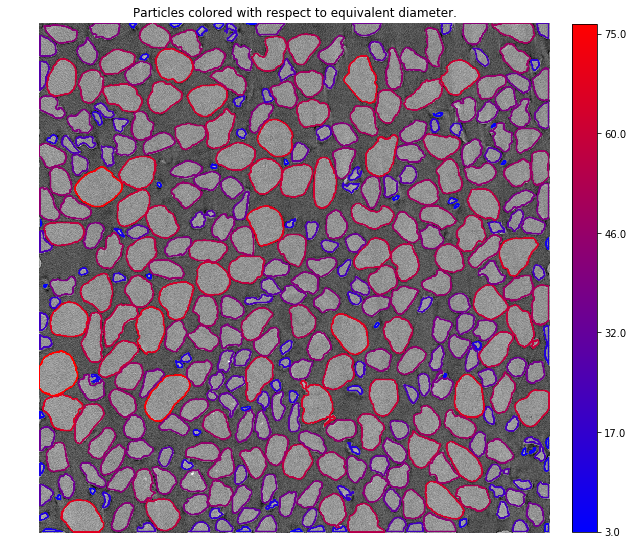

In [14]:
colormap = colors.LinearSegmentedColormap.from_list("BuRd", [(0,0,1), (1,0,0)], 256)
show(contours_colored, 'Particles colored with respect to equivalent diameter.', (10,10), colormap)

cbar = plt.colorbar(fraction=0.0455, pad=0.04)
interp = lambda x: (int(x)*(max_-min_)+255*min_)//255
_ = cbar.ax.set_yticklabels([interp(l.get_text()) for l in cbar.ax.get_yticklabels()])

plt.savefig('./results/contours_colored.png', dpi=200)

#### 7. Size distribution.

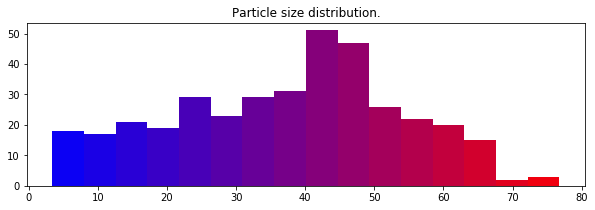

In [15]:
plt.figure(figsize=(10,3))
plt.title('Particle size distribution.')
nums, bins, patches = plt.hist(equivalent_diameters, bins=16)
bins /= max(bins)

for b, p in zip(bins, patches):
    plt.setp(p, 'facecolor', colormap(b))

plt.savefig('./results/size_distribution.png', dpi=150)